# ResNet101v2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d gpiosenka/100-bird-species

100% 1.16G/1.17G [00:13<00:00, 85.4MB/s]
100% 1.17G/1.17G [00:13<00:00, 94.9MB/s]


In [ ]:
!unzip 100-bird-species.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: train/TURQUOISE MOTMOT/043.jpg  
  inflating: train/TURQUOISE MOTMOT/044.jpg  
  inflating: train/TURQUOISE MOTMOT/045.jpg  
  inflating: train/TURQUOISE MOTMOT/046.jpg  
  inflating: train/TURQUOISE MOTMOT/047.jpg  
  inflating: train/TURQUOISE MOTMOT/048.jpg  
  inflating: train/TURQUOISE MOTMOT/049.jpg  
  inflating: train/TURQUOISE MOTMOT/050.jpg  
  inflating: train/TURQUOISE MOTMOT/051.jpg  
  inflating: train/TURQUOISE MOTMOT/052.jpg  
  inflating: train/TURQUOISE MOTMOT/053.jpg  
  inflating: train/TURQUOISE MOTMOT/054.jpg  
  inflating: train/TURQUOISE MOTMOT/055.jpg  
  inflating: train/TURQUOISE MOTMOT/056.jpg  
  inflating: train/TURQUOISE MOTMOT/057.jpg  
  inflating: train/TURQUOISE MOTMOT/058.jpg  
  inflating: train/TURQUOISE MOTMOT/059.jpg  
  inflating: train/TURQUOISE MOTMOT/060.jpg  
  inflating: train/TURQUOISE MOTMOT/061.jpg  
  inflating: train/TURQUOISE MOTMOT/062.jpg  
  inflating: train/TURQUOISE M

Distractor:

In [ ]:
!unzip -q '/content/drive/My Drive/CV_Birds/mirflickr.zip' -d '/content'

## Dataset creation
Here all the dataset needed are created:

In [ ]:
import tensorflow as tf

In [ ]:
TRAIN_DIR = 'train/'
VALID_DIR = 'valid/'
TEST_DIR = 'test/'
DISTRACTOR_DIR = 'mirflickr'
BATCH_SIZE = 128
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
RANDOM_SEED = 42

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, interpolation='bilinear')

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=False, seed=RANDOM_SEED, interpolation='bilinear')

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VALID_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=False, seed=RANDOM_SEED, interpolation='bilinear')

Found 47332 files belonging to 325 classes.
Found 1625 files belonging to 325 classes.
Found 1625 files belonging to 325 classes.


In [ ]:
NUM_CLASSES = len(training_images.class_names)

In [ ]:
distractor_images = tf.keras.preprocessing.image_dataset_from_directory(
    DISTRACTOR_DIR,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    seed=RANDOM_SEED,
    labels=None,
    label_mode=None)

Found 25000 files belonging to 1 classes.


## Utils for plotting

In [ ]:
def plot_model(model, model_name):
    ks.utils.plot_model(model, model_name, show_shapes=True)

def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(range(1, len(acc) + 1), acc, 'r', label='Training Accuracy')
    plt.plot(range(1, len(acc) + 1), val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.plot()

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
    plt.plot(range(1, len(loss) + 1), val_loss, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.plot()

## ResNet101 Functions

Needed imports:

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras import regularizers
import pathlib
import matplotlib.pyplot as plt
import numpy as np

Data augmentation object

In [ ]:
data_augmentation = ks.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1)
    ]
)

The following cells contains function usedful for the creation of all the tested models later proposed:

In [ ]:
def input(data_augmentation=None):
    inputs = ks.Input(shape=(224, 224, 3))
    x = ks.applications.resnet50.preprocess_input(inputs)
    if data_augmentation is not None:
        x = data_augmentation(x)
    return x

In [ ]:
def base_resnet101v2():
    res = ResNet101V2(
        weights='imagenet',
        include_top=False,
        input_shape=((224, 224, 3)),
        pooling='avg'
    )
    res.trainable = False
    return res

In [ ]:
def fine_tuning(num_of_blocks=1):
    if num_of_blocks < 1:
        num_of_blocks = 1

    res = base_resnet101v2()
    res.trainable = True
    set_trainable = False

    if num_of_blocks == 1:
        block_name = 'conv4_block19_out'
    elif num_of_blocks == 2:
        block_name = 'conv4_block10_out'
    elif num_of_blocks == 3:
        block_name = 'conv4_block6_out'
    elif num_of_blocks == 4:
        block_name = 'conv4_block5_out'
    else:
        block_name = 'conv4_block2_out'

    for layer in res.layers:
        if layer.name == block_name:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    return res

### ResNet101 Feature extraction

In [ ]:
def resnet101_feature_extraction(data_augmentation=None):
    inputs = input(data_augmentation)
    outputs = base_resnet101v2()(inputs)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = resnet101_feature_extraction()

171327488/171317808 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
Total params: 42,626,560
Trainable params: 0
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
features = model.predict(training_images, batch_size=BATCH_SIZE, verbose=True)

370/370 [==============================] - 424s 1s/step


Save features:

In [ ]:
np.save('/content/drive/MyDrive/CV_Birds/features/training/ResNet101v2/resnet101_fe_features.npy', features)

Features for test set:

In [ ]:
features = model.predict(test_images, batch_size=BATCH_SIZE, verbose=True)

13/13 [==============================] - 17s 1s/step


In [ ]:
np.save('/content/drive/MyDrive/CV_Birds/features/test/ResNet101v2/resnet101_fe_features.npy', features)

Features for distractor set:

In [ ]:
features = model.predict(distractor_images, batch_size=BATCH_SIZE, verbose=True)

196/196 [==============================] - 240s 1s/step


In [ ]:
np.save('/content/drive/MyDrive/CV_Birds/features/distractor/ResNet101v2/resnet101_fe_features.npy', features)

## Model 1: Fine tuning from block4_conv19_out

In [ ]:
def finetuned_resnet101(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='resNet101_model1.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model1 = finetuned_resnet101(NUM_CLASSES, num_of_blocks=1, data_augmentation=data_augmentation)
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 43,292,485
Trainable params: 20,109,637
Non-trainable params: 23,182,848
_________________________________________________________________


In [ ]:
model1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model1.fit(
    training_images,
    epochs=40,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/40
370/370 [==============================] - ETA: 0s - loss: 4.4259 - accuracy: 0.1209

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 361s 949ms/step - loss: 4.4259 - accuracy: 0.1209 - val_loss: 2.8544 - val_accuracy: 0.3188
Epoch 2/40
370/370 [==============================] - 346s 933ms/step - loss: 2.2534 - accuracy: 0.4648 - val_loss: 1.4890 - val_accuracy: 0.6191
Epoch 3/40
370/370 [==============================] - 344s 928ms/step - loss: 1.3424 - accuracy: 0.6622 - val_loss: 1.1194 - val_accuracy: 0.7022
Epoch 4/40
370/370 [==============================] - 343s 924ms/step - loss: 0.8147 - accuracy: 0.7871 - val_loss: 1.0467 - val_accuracy: 0.7262
Epoch 5/40
370/370 [==============================] - 341s 920ms/step - loss: 0.4479 - accuracy: 0.8814 - val_loss: 0.9924 - val_accuracy: 0.7477
Epoch 6/40
370/370 [==============================] - 332s 896ms/step - loss: 0.2361 - accuracy: 0.9403 - val_loss: 0.9033 - val_accuracy: 0.7754
Epoch 7/40
370/370 [==============================] - 330s 890ms/step - loss: 0.1256 - accuracy: 0.9702 - val_loss: 0.9665 - val_accura

Plotting loss and accuracy:

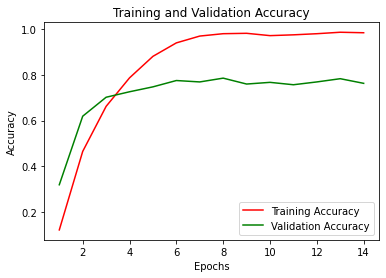

In [ ]:
plot_accuracy(history)

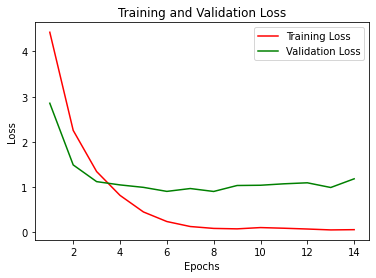

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model1.evaluate(test_images)

13/13 [==============================] - 9s 702ms/step - loss: 0.7106 - accuracy: 0.8142


[0.7106322646141052, 0.8141538500785828]

Save model:

In [ ]:
ks.models.save_model(model1, 'resNet101_model1.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 2: Finetuning from conv4_block13_out

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model2.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model2 = finetuned_resnet101(NUM_CLASSES, num_of_blocks=2, data_augmentation=data_augmentation)
model2.summary()

171327488/171317808 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 43,292,485
Trainable params: 30,173,509
Non-trainable params: 13,118,976
_________________________________________________________________


In [ ]:
model2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model2.fit(
    training_images,
    epochs=20,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/20
370/370 [==============================] - ETA: 0s - loss: 3.9851 - accuracy: 0.1844

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 962s 3s/step - loss: 3.9851 - accuracy: 0.1844 - val_loss: 2.3105 - val_accuracy: 0.4449
Epoch 2/20
370/370 [==============================] - 929s 3s/step - loss: 1.7428 - accuracy: 0.5728 - val_loss: 1.1453 - val_accuracy: 0.6905
Epoch 3/20
370/370 [==============================] - 927s 3s/step - loss: 0.9773 - accuracy: 0.7498 - val_loss: 0.8939 - val_accuracy: 0.7508
Epoch 4/20
370/370 [==============================] - 928s 3s/step - loss: 0.5397 - accuracy: 0.8565 - val_loss: 0.7490 - val_accuracy: 0.7828
Epoch 5/20
370/370 [==============================] - 926s 2s/step - loss: 0.2647 - accuracy: 0.9318 - val_loss: 0.7917 - val_accuracy: 0.7822
Epoch 6/20
370/370 [==============================] - 927s 3s/step - loss: 0.1384 - accuracy: 0.9661 - val_loss: 0.7521 - val_accuracy: 0.8031
Epoch 7/20
370/370 [==============================] - 928s 3s/step - loss: 0.0866 - accuracy: 0.9796 - val_loss: 0.7587 - val_accuracy: 0.8166
Epoch 8/20

Plotting loss and accuracy:

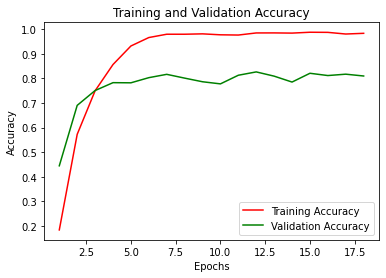

In [ ]:
plot_accuracy(history)

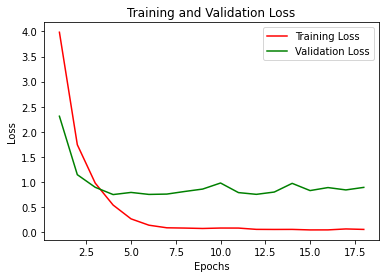

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model2.evaluate(test_images)

13/13 [==============================] - 17s 1s/step - loss: 0.5814 - accuracy: 0.8615


[0.5813584327697754, 0.8615384697914124]

Save model:

In [ ]:
ks.models.save_model(model2, 'model2.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
